# Make initial conditions file for 01deg_jra55v13_ryf9091_DSW5m
### reggrid from 01deg_jra55v13_ryf9091 initial conditions

In [2]:
import netCDF4
import xarray as xr
import xesmf as xe
from itertools import cycle
import os
import dask
import numpy as np
import pandas as pd
import dask.array as da
import dask.bag as db
from pykdtree.kdtree import KDTree
from dask.diagnostics import ProgressBar
import subprocess
import matplotlib.pyplot as plt
from glob import glob
import cmocean.cm as cmocean
import logging
#logging.captureWarnings(True)
#logging.getLogger('py.warnings').setLevel(logging.ERROR)
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

xr.set_options(keep_attrs=True) ## This ensures that performing simple operations with xarray (eg converting temperature to Celsius) preserves attributes

from dask.distributed import Client
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37519,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:40017,Total threads: 1
Dashboard: /proxy/37671/status,Memory: 35.97 GiB
Nanny: tcp://127.0.0.1:38539,


## Open IC 1 from 01deg_jra55v13_ryf9091

In [3]:
# ACCESS-OM2 temp at year 2, 31 December:
ACCESS_OM2_temp = xr.open_dataset("/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/ocean_temp_salt.res.nc")
ACCESS_OM2_temp = ACCESS_OM2_temp.temp.isel(time=0).squeeze() 


ACCESS_OM2_salt = xr.open_dataset("/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/ocean_temp_salt.res.nc")
ACCESS_OM2_salt = ACCESS_OM2_salt.salt.isel(time=0).squeeze()

data_in = xr.Dataset({'temp': ACCESS_OM2_temp,'salt':ACCESS_OM2_salt})

/home/156/wf4500/.local/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/156/wf4500/.local/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/home/156/wf4500/.local/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/156/wf4500/.local/lib/python3.9/site-packages/xarray/core/indexing

In [3]:
data_in

<xarray.Dataset>
Dimensions:   (GRID_X_T: 3600, GRID_Y_T: 2700, ZT: 75)
Coordinates:
  * GRID_X_T  (GRID_X_T) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * GRID_Y_T  (GRID_Y_T) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * ZT        (ZT) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
    time      object 0001-01-02 12:00:00
Data variables:
    temp      (ZT, GRID_Y_T, GRID_X_T) float64 ...
    salt      (ZT, GRID_Y_T, GRID_X_T) float64 ...

In [4]:
# interp:

import xarray as xr
import xesmf as xe

# target grid (t points)
dg = xr.open_dataset("/g/data/v45/wf4500/DSW_collaborative/topog_KDZ75_5mdz/5mdz__grid_for_MOM5.nc")
dg = (
    dg[["zeta"]]
    .isel(nzv=slice(1, None, 2))
    .rename(zeta="ZT",nzv='ZT')
)


outgrid = data_in.drop_vars('temp').drop_vars('salt').drop_vars('ZT')

outgrid['ZT']=dg['ZT']
outgrid


<xarray.Dataset>
Dimensions:   (GRID_X_T: 3600, GRID_Y_T: 2700, ZT: 60)
Coordinates:
  * GRID_X_T  (GRID_X_T) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * GRID_Y_T  (GRID_Y_T) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    time      object 0001-01-02 12:00:00
  * ZT        (ZT) float64 2.678 8.314 14.54 ... 5.471e+03 5.669e+03 5.867e+03
Data variables:
    *empty*

In [5]:
import os
os.chdir('/g/data/v45/wf4500/DSW_collaborative/input_01deg_jra55v13_ryf9091_DSW5m')
os.getcwd()

'/g/data/v45/wf4500/DSW_collaborative/input_01deg_jra55v13_ryf9091_DSW5m'

In [6]:
#grids for xarray interp
lon=outgrid['GRID_X_T']
lat=outgrid['GRID_Y_T']
zout=outgrid['ZT']
zin=data_in['ZT']


In [7]:
#actual regridding
data_out=data_in.interp(GRID_X_T=lon,GRID_Y_T=lat,ZT=zout)

In [22]:
# last cell of the new grid is deeper than the last cell of the old grid. 
#So I will just repeat the penultimate cell, eg temp,salt(:,:,ZT=59)=temp,salt(:,:,ZT=58)'
data_out2 = data_out.where(data_out['ZT']<=5669,data_out.isel(ZT=58))
#checking data
data_out2

<xarray.Dataset>
Dimensions:   (ZT: 60, GRID_Y_T: 2700, GRID_X_T: 3600)
Coordinates:
    time      object 0001-01-02 12:00:00
  * GRID_X_T  (GRID_X_T) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * GRID_Y_T  (GRID_Y_T) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * ZT        (ZT) float64 2.678 8.314 14.54 ... 5.471e+03 5.669e+03 5.867e+03
Data variables:
    temp      (ZT, GRID_Y_T, GRID_X_T) float64 1.171 1.627 ... -2.108 -2.108
    salt      (ZT, GRID_Y_T, GRID_X_T) float64 24.13 33.53 33.53 ... 35.55 35.55

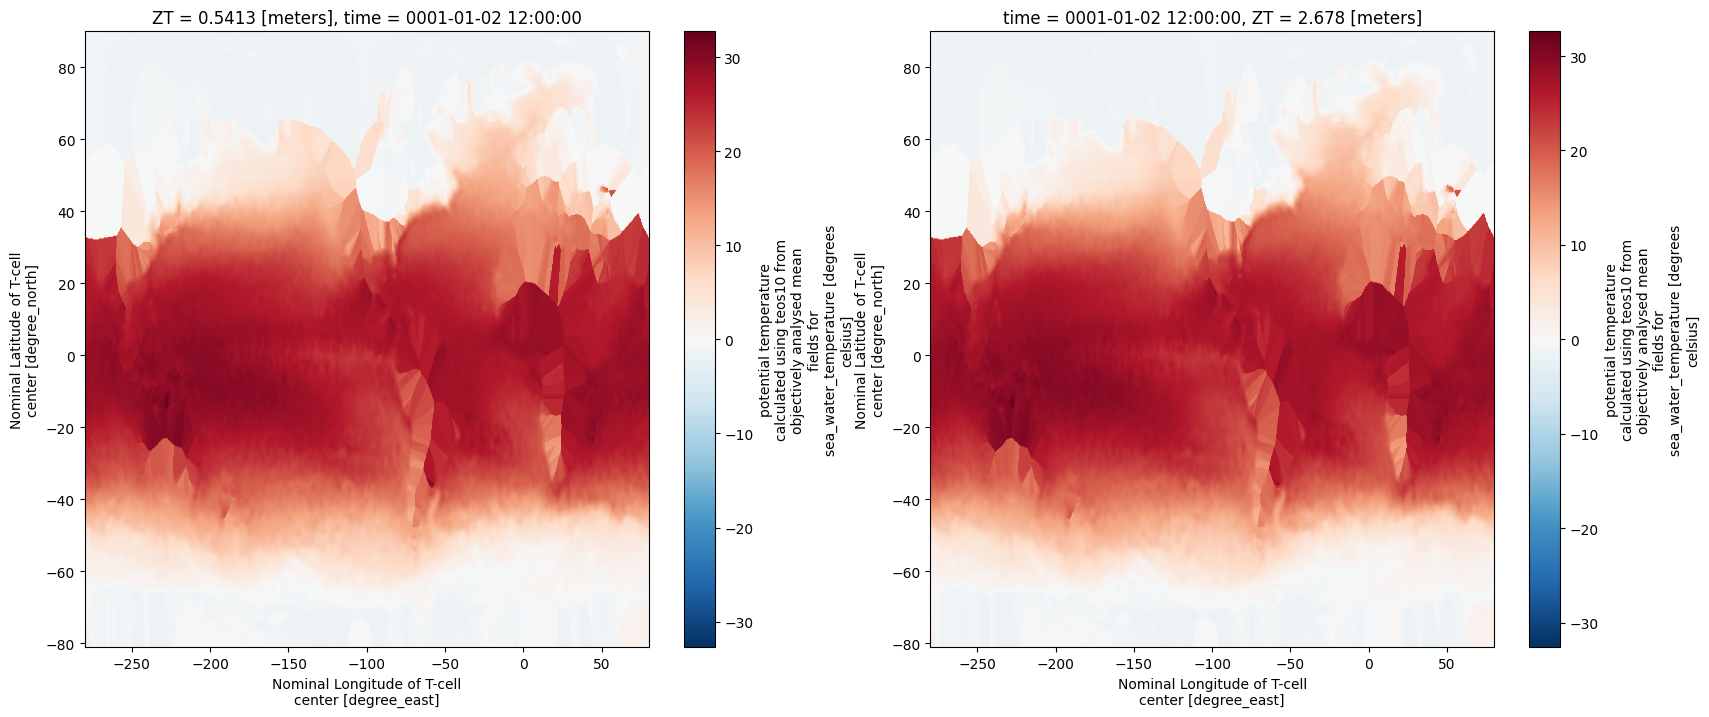

In [26]:
#plotting data - surface temp
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
#input data
data_in['temp'].isel(ZT=0).plot(ax=ax1)
plt.title('Surface input, Zt˜1.6m')
#output data
data_out2['temp'].isel(ZT=0).plot(ax=ax2)

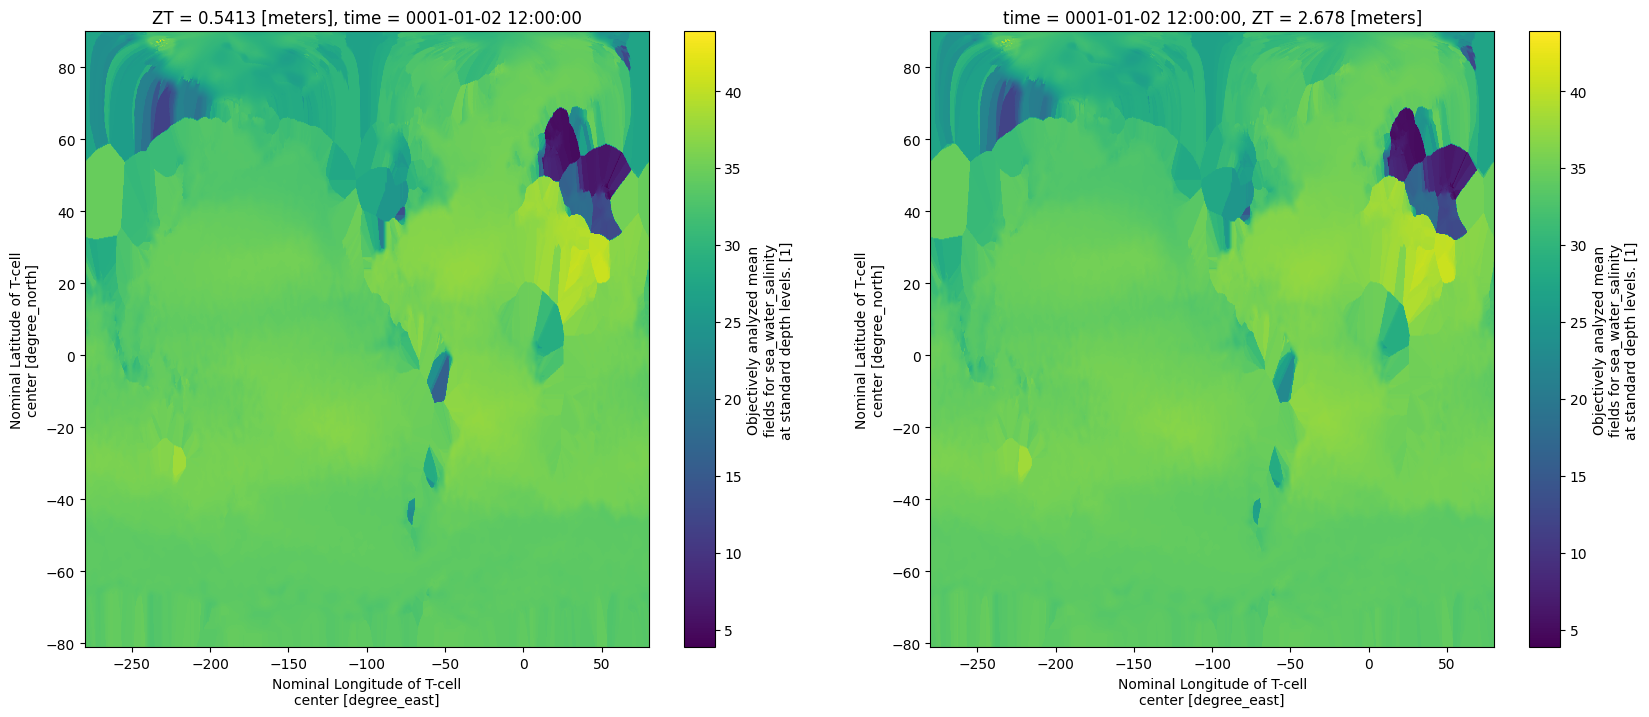

In [27]:
#plotting data - surface Salinity
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
#input data
data_in['salt'].isel(ZT=0).plot(ax=ax1)
#output data
data_out2['salt'].isel(ZT=0).plot(ax=ax2)

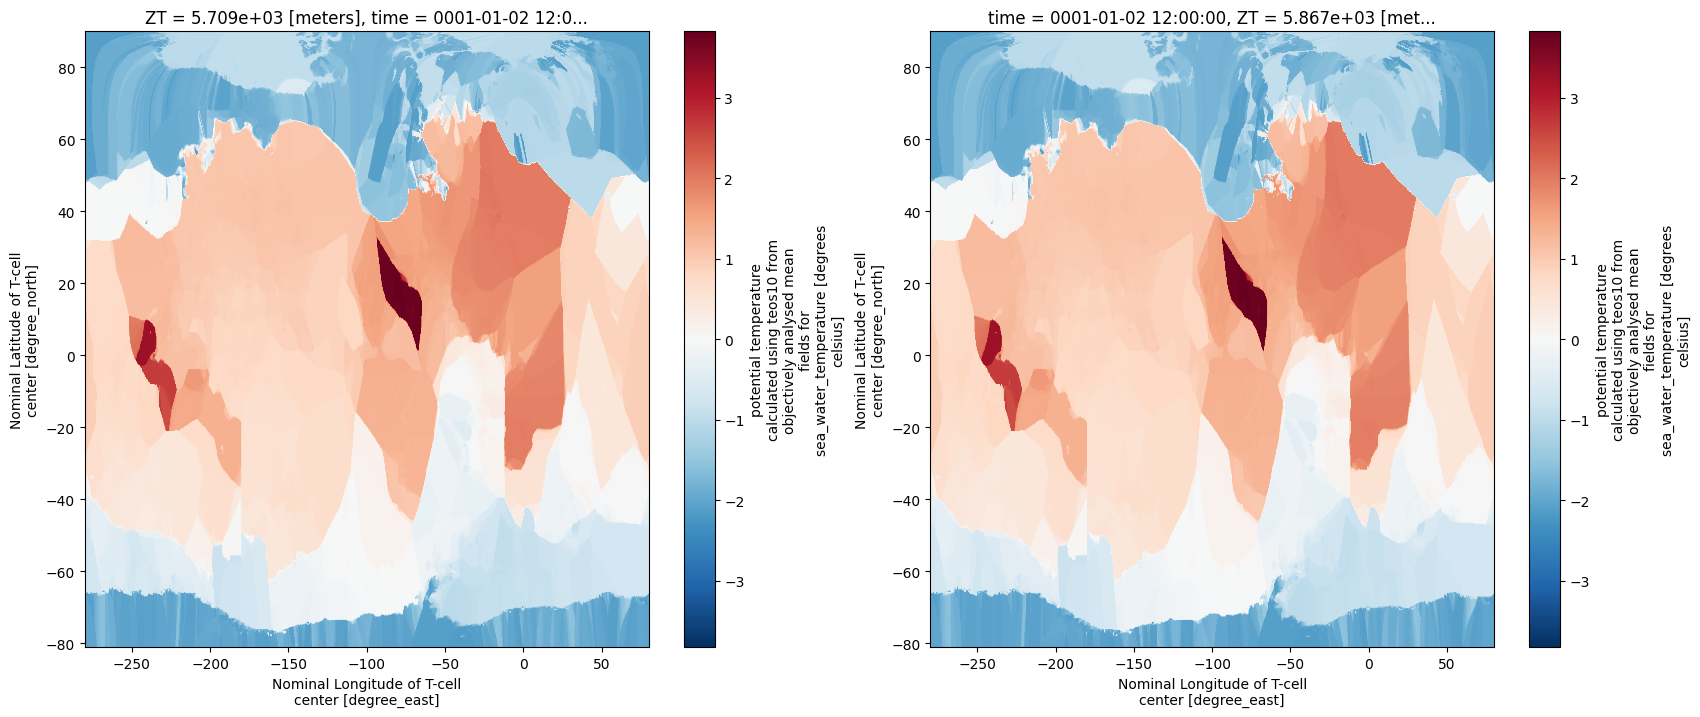

In [28]:
#plotting data - bottom temp
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
#input data
data_in['temp'].isel(ZT=74).plot(ax=ax1)
#output data
data_out2['temp'].isel(ZT=59).plot(ax=ax2)

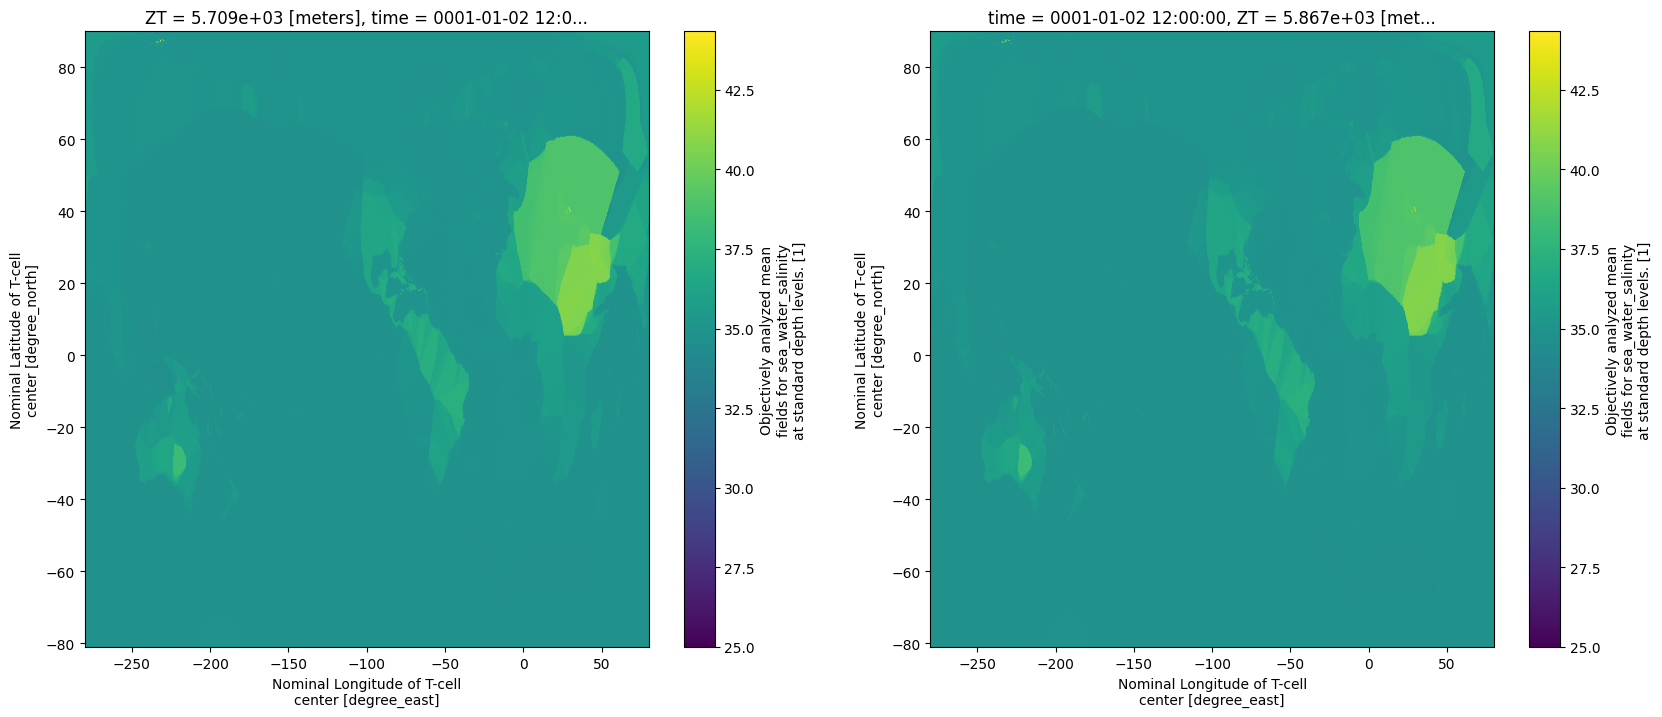

In [29]:
#plotting data - bottom salinity
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
#input data
data_in['salt'].isel(ZT=74).plot(ax=ax1)

#output data
data_out2['salt'].isel(ZT=59).plot(ax=ax2)

In [30]:
#saving
enc = {
    "_FillValue": -1.e+34
}

# Make them doubles:
data_out2['temp'] = data_out2['temp'].astype('double')
data_out2['salt'] = data_out2['salt'].astype('double')

data_out2.to_netcdf("/g/data/v45/wf4500/DSW_collaborative/input_01deg_jra55v13_ryf9091_DSW5m/ocean_temp_salt.res.nc", encoding={"temp": enc, "salt": enc})
